# Image matching dataset
- Download the dataset from Kaggle competition page: [Image Matching Challenge 2025](https://www.kaggle.com/competitions/image-matching-challenge-2025/data)
- Custom Dataset class to load the dataset
- Normalize the images with mean and std of 0.5 for all channels.

In [1]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch
from torchvision.transforms.functional import pad

class PadToSize():
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        pad_h = max(0, self.size - h)
        pad_w = max(0, self.size - w)
        padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
        return pad(img, padding, fill=self.fill)

        
'''Original dataset, no resizing performed, does not work with dataloader since it requires all images of same dimensions'''
train_dataset = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

'''train_dataset_resize = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.Resize((1024, 1024)),
                                   transforms.Pad((0, 0, 1024, 1024), fill=0),
                                   transforms.ToTensor()
                               ]))'''


'''Dataset with resizing and padding if needed, to be used with dataloader to work in batches'''
train_dataset_eq_size = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   PadToSize(1024, fill=0),
                                   transforms.Resize((1024, 1024), antialias=True),
                                   transforms.ToTensor()
                               ]))

## Initial Analysis of the dataset

## Creating descriptors for the dataset and saving them

'Total images in the training label csv:'

1945

'Total length of the dataset:'

1945

<Axes: title={'center': 'Scene distribution'}, xlabel='scene'>

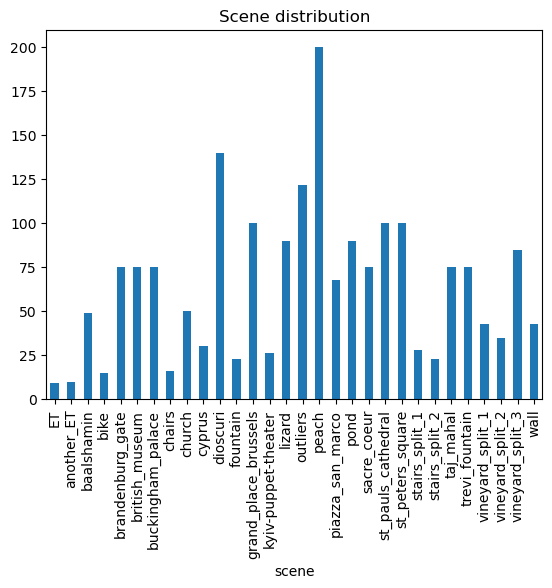

In [24]:
import pandas as pd

labels = pd.read_csv('data/train_labels.csv')
display('Total images in the training label csv:',labels.count().dataset)
display('Total length of the dataset:',train_dataset.__len__())

labels.groupby('scene').count().dataset.plot(kind='bar', title="Scene distribution")

In [63]:
display('Total outliers in the dataset',labels.groupby('scene').get_group('outliers').count().dataset)

'Total outliers in the dataset'

122

<Axes: title={'center': 'Outliers in each dataset'}, xlabel='dataset'>

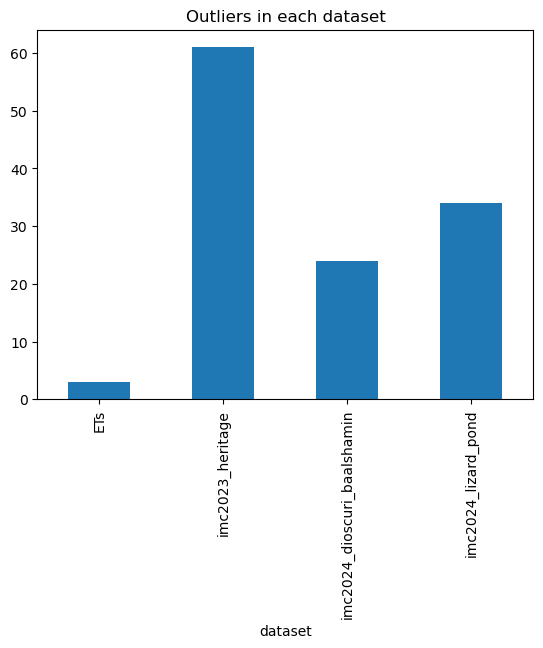

In [95]:
labels[labels['scene']=='outliers'].groupby('dataset').size().plot(kind='bar',title='Outliers in each dataset')

In [107]:
#labels.groupby(['dataset','scene']).count()
# Combination of each dataset and scene and total images for each

In [105]:
display(labels.groupby('dataset')['scene'].nunique())
display('Number of scenes per dataset')

dataset
ETs                                  3
amy_gardens                          1
fbk_vineyard                         3
imc2023_haiper                       3
imc2023_heritage                     4
imc2023_theather_imc2024_church      2
imc2024_dioscuri_baalshamin          3
imc2024_lizard_pond                  3
pt_brandenburg_british_buckingham    3
pt_piazzasanmarco_grandplace         2
pt_sacrecoeur_trevi_tajmahal         3
pt_stpeters_stpauls                  2
stairs                               2
Name: scene, dtype: int64

'Number of scenes per dataset'

# Dataset loading using dataloader and running each combination of descriptor + matcher

In [2]:
from torch.utils.data import DataLoader

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset_eq_size, batch_size=8, shuffle=True, num_workers=4,pin_memory=True)

#train_features = next(iter(train_loader))
#print(f'Keys of the batch: {train_features.keys()}')
#print(f"Feature batch shape: {train_features['image'].size()}")
#print(f"Labels size: {labels.size}")


In [ ]:
''' Pseudo dataset containing descriptor pairs of each image so that we do not have to care about batching for each dataset.
Assuming descriptors saved in folders, where each file contains dataset name, image name and descriptor and key points.
Pseudo dataset will contain all the information(keys or columns of original dataset) for both the images image1 and image2.
Also, assuming the SIFT and DISK returns 'keypoints', 'keypoint_scores', 'descriptors', 'image_size' for each image.
'''

'''pseudo_dataset = PseudoMatchingDataset(
    labels_path='data/train_labels.csv',
    descriptors_dir='data/descriptors',
    descriptor_type='sift'
)

dataloader = DataLoader(
    pseudo_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)'''



In [3]:
from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features
import os, h5py

import kornia

def save_result(save_dir,extractor,i,image, image_size, dataset_name, scene_name,image_name, image_path, res):
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, f"{i}_1024_{extractor}.h5")
    dt = h5py.string_dtype(encoding="utf-8")
    with h5py.File(out_path, 'w') as f:
        f.create_dataset('keypoints', data=res['keypoints'].cpu().detach().numpy())
        f.create_dataset('keypoint_scores', data=res['keypoint_scores'].cpu().detach().numpy())
        f.create_dataset('descriptors', data=res['descriptors'].cpu().detach().numpy())
        f.create_dataset('keypoints_mask', data=res['keypoints_mask'].cpu().detach().numpy())
        f.create_dataset('image', data=image.cpu().detach().numpy())
        f.create_dataset('image_size', data=image_size.cpu().detach().numpy())
        f.create_dataset('image_name', data=image_name, dtype=dt)
        f.create_dataset('dataset_name', data=dataset_name, dtype=dt)
        f.create_dataset('scene_name', data=scene_name, dtype=dt)
        f.create_dataset('image_path', data=image_path, dtype=dt)




for i,batch in enumerate(train_loader):
    torch.cuda.empty_cache()
    features = get_DISK_features(batch['image'].to(DEVICE), device = DEVICE)
    save_result('evaluation/disk_descriptors_outputs/','disk',i,batch['image'], batch['image_size'],batch['dataset_name'], batch['scene_name'],batch['image_name'],batch['image_path'],features)
    del features
    

In [ ]:
import h5py
import numpy as np
from pathlib import Path
'''To check if there are any zeros/false in mask for identifying the images which have been padded'''
root = Path("evaluation/disk_descriptors_outputs")

for h5_path in sorted(root.glob("*.h5")):
    print(f"\n=== {h5_path.name} ===")
    with h5py.File(h5_path, "r") as f:
        # Optional: show structure
        # f.visititems(print_h5_structure)

        if "keypoints_mask" not in f:
            print("keypoints_mask not found")
            continue

        mask = f["keypoints_mask"][:]  # shape (B, Nmax) typically
        zeros = np.where(mask == 0)
        total_zeros = zeros[0].size
        print(f"total zeros: {total_zeros}")

        # If you want the exact indices (batch_idx, kp_idx), print a small sample:
        if total_zeros > 0:
            sample = list(zip(zeros[0], zeros[1]))[:50]
            print(f"indices sample (up to 50): {sample}")

In [4]:
import h5py
import numpy as np
from pathlib import Path
import glob

root = Path("evaluation/disk_descriptors_outputs")
file_gen = root.glob("[0-9]*.h5")

if not file_gen:
    raise ValueError("No .h5 files found in the folder.")

first_file = next(file_gen)
with h5py.File(first_file, "r") as f:
    keys = list(f.keys())


with h5py.File(root / "merged.h5", "w") as fout:

    for key in keys:
        # Determine the dtype and initial shape from first file
        with h5py.File(first_file, "r") as f:
            data = f[key][...]
        fout.create_dataset(key, data=data, maxshape=(None,) + data.shape[1:])

    #iterate over the remaining files
    for filepath in file_gen:  
        with h5py.File(filepath, "r") as f:
            for key in keys:
                old_data = fout[key]
                new_data = f[key][...]
                old_len = old_data.shape[0]
                new_len = new_data.shape[0]
                old_data.resize(old_len + new_len, axis=0)
                old_data[old_len:] = new_data


In [8]:
import h5py
import numpy as np
def print_h5_structure(name, obj):
    print(name)

with h5py.File("evaluation/matches_output/disk_lightglue_matches/4174_lightglue_disk.h5", "r") as f:
    for key in f.keys():
        num_rows = f[key]
        print(f"{key}: {num_rows} rows")

0: <HDF5 group "/0" (7 members)> rows
1: <HDF5 group "/1" (7 members)> rows
10: <HDF5 group "/10" (7 members)> rows
11: <HDF5 group "/11" (7 members)> rows
12: <HDF5 group "/12" (7 members)> rows
13: <HDF5 group "/13" (7 members)> rows
14: <HDF5 group "/14" (7 members)> rows
15: <HDF5 group "/15" (7 members)> rows
16: <HDF5 group "/16" (7 members)> rows
17: <HDF5 group "/17" (7 members)> rows
18: <HDF5 group "/18" (7 members)> rows
19: <HDF5 group "/19" (7 members)> rows
2: <HDF5 group "/2" (7 members)> rows
20: <HDF5 group "/20" (7 members)> rows
21: <HDF5 group "/21" (7 members)> rows
22: <HDF5 group "/22" (7 members)> rows
23: <HDF5 group "/23" (7 members)> rows
24: <HDF5 group "/24" (7 members)> rows
25: <HDF5 group "/25" (7 members)> rows
26: <HDF5 group "/26" (7 members)> rows
27: <HDF5 group "/27" (7 members)> rows
28: <HDF5 group "/28" (7 members)> rows
29: <HDF5 group "/29" (7 members)> rows
3: <HDF5 group "/3" (7 members)> rows
30: <HDF5 group "/30" (7 members)> rows
31: <HDF

In [11]:
from data_preprocess.image_pair_csv_dataset import ImagePairCsv
import pandas as pd

image_pair_csv = ImagePairCsv(labels_path='data/train_labels.csv', output_dir='data/train_pairs')

pairs_csv = pd.read_csv('data/train_pairs/data_pairs.csv')
print(pairs_csv.count()/48)

image1     3691.625
image2     3691.625
dataset    3691.625
dtype: float64


In [6]:
len(train_loader)

3692

In [ ]:
import h5py
from pathlib import Path
from feature_matching.lightglue_matcher import match_features_for_plots
import cv2 as cv
import numpy as np
from batch_matcher import process_batches
import os

# Set up output path
output_dir = Path('evaluation/matches_output/')

# Initialize output files for both matchers
lightglue_output = os.path.join(output_dir,'disk_lightglue_matches' )
output_dir.parent.mkdir(exist_ok=True, parents=True)

flann_output = output_dir / 'disk_flann_matches'
print(lightglue_output)

# Run both matchers
print("Running LightGlue matching...")
lightglue_matches = process_batches(
    train_loader,
    output_path=lightglue_output,
    device = DEVICE
)

'''print("\nRunning FLANN matching...")
flann_matches = process_batches(
    train_loader,
    matcher='flann',
    output_path=flann_output
)
'''
print("\nMatching complete!")
print(f"LightGlue matches saved to: {lightglue_output}")


evaluation/matches_output/disk_lightglue_matches
Running LightGlue matching...
Processing 3692 batches...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [8]:

from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features

feats0 = get_SIFT_features(train_dataset[12].get('image_path'))
print(feats0['keypoints'].size())
print(feats0['descriptors'].size())

feats01 = get_SIFT_features(train_dataset[12].get('image_path'))
#print(feats01)

points0, points1 = match_features(image0_features=feats0, image1_features=feats01, descriptor='sift')

#print(len(points0))
#print(len(points1))

feats0 = get_DISK_features(train_dataset[1100].get('image_path'))
print(feats0.keys())
print(feats0['keypoints'].size())
print(feats0['descriptors'].size())
feats01 = get_DISK_features(train_dataset[1000].get('image_path'))
print(feats01.keys())
print(feats01['keypoints'].size())
print(feats01['descriptors'].size())

torch.Size([1, 1522, 2])
torch.Size([1, 1522, 128])
dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 128])
dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 128])


In [1]:

def print_evaluation_results(results: dict):
    """Print formatted evaluation results"""
    print(f"Cluster Evaluation Results:")
    print(f"---------------------------")
    print(f"Total Clusters: {results['total_clusters']}")
    print(f"Correct Clusters: {results['correct_clusters']}")
    print(f"Scene Purity: {results['scene_purity']:.2%}")
    print("\nPer-cluster Statistics:")
    
    for cluster_id, stats in results['per_cluster_stats'].items():
        print(f"\nCluster {cluster_id}:")
        print(f"  Size: {stats['size']} images")
        print(f"  Pure cluster: {stats['is_pure']}")
        print(f"  Number of scenes: {stats['num_scenes']}")
        print(f"  Scenes: {', '.join(stats['scenes'])}")

In [2]:
data_fake_cluster = {0: ['peach_0019.png', 'peach_0067.png', 'peach_0166.png'],
 1: ['peach_0010.png',
   'peach_0015.png',
   'peach_0032.png',
   'peach_0068.png',
   'peach_0069.png',
   'peach_0115.png',
   'peach_0123.png',
   'peach_0133.png',
   'peach_0142.png',
   'peach_0144.png',
   'peach_0147.png',
   'peach_0158.png',
   'peach_0165.png',
   'peach_0168.png',
   'peach_0186.png'],
 2: ['peach_0006.png',
   'peach_0020.png',
   'peach_0024.png',
   'peach_0026.png',
   'peach_0040.png',
   'peach_0084.png',
   'peach_0116.png',
   'peach_0118.png',
   'peach_0127.png'],
 5: ['peach_0013.png', 'peach_0096.png', 'peach_0181.png']}

In [3]:
from evaluation.eval import evaluate_clusters

evaluate_clusters(data_fake_cluster, labels_path='data/train_labels.csv')

scene
ET                        9
another_ET               10
baalshamin               49
bike                     15
brandenburg_gate         75
british_museum           75
buckingham_palace        75
chairs                   16
church                   50
cyprus                   30
dioscuri                140
fountain                 23
grand_place_brussels    100
kyiv-puppet-theater      26
lizard                   90
outliers                122
peach                   200
piazza_san_marco         68
pond                     90
sacre_coeur              75
st_pauls_cathedral      100
st_peters_square        100
stairs_split_1           28
stairs_split_2           23
taj_mahal                75
trevi_fountain           75
vineyard_split_1         43
vineyard_split_2         35
vineyard_split_3         85
wall                     43
Name: image, dtype: int64
{'peach_0019.png', 'peach_0166.png', 'peach_0067.png'}
{'peach_0133.png', 'peach_0168.png', 'peach_0123.png', 'peach_0010.png', 

{'overall_mAA': 0.0025,
 'overall_clustering_score': 0.03333333333333333,
 'combined_score': 0.004651162790697674,
 'per_scene_results': {'ET': {'cluster_id': 0,
   'mAA': 0.0,
   'clustering_score': 0.0},
  'another_ET': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'baalshamin': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'bike': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'brandenburg_gate': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'british_museum': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'buckingham_palace': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'chairs': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'church': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'cyprus': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'dioscuri': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'fountain': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'gran

# Image matching dataset
- Download the dataset from Kaggle competition page: [Image Matching Challenge 2025](https://www.kaggle.com/competitions/image-matching-challenge-2025/data)
- Custom Dataset class to load the dataset
- Normalize the images with mean and std of 0.5 for all channels.

In [ ]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch
from torchvision.transforms.functional import pad

class PadToSize():
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        pad_h = max(0, self.size - h)
        pad_w = max(0, self.size - w)
        padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
        return pad(img, padding, fill=self.fill)

        
'''Original dataset, no resizing performed, does not work with dataloader since it requires all images of same dimensions'''
train_dataset = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

'''train_dataset_resize = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.Resize((1024, 1024)),
                                   transforms.Pad((0, 0, 1024, 1024), fill=0),
                                   transforms.ToTensor()
                               ]))'''


'''Dataset with resizing and padding if needed, to be used with dataloader to work in batches'''
train_dataset_eq_size = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   PadToSize(1024, fill=0),
                                   transforms.Resize((1024, 1024), antialias=True),
                                   transforms.ToTensor()
                               ]))

## Initial Analysis of the dataset

## Creating descriptors for the dataset and saving them

'Total images in the training label csv:'

1945

'Total length of the dataset:'

1945

<Axes: title={'center': 'Scene distribution'}, xlabel='scene'>

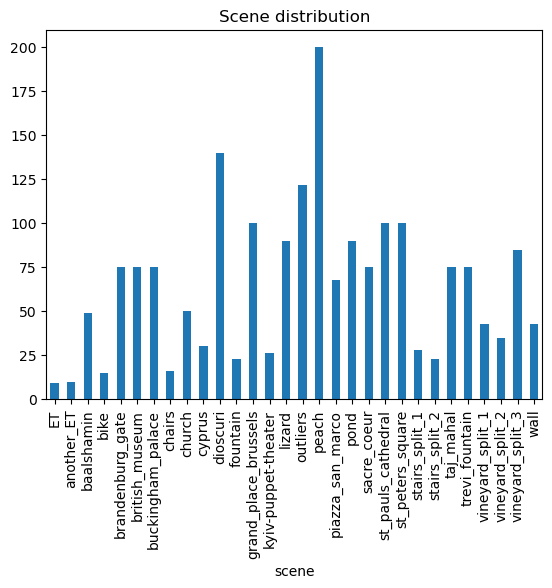

In [24]:
import pandas as pd

labels = pd.read_csv('data/train_labels.csv')
display('Total images in the training label csv:',labels.count().dataset)
display('Total length of the dataset:',train_dataset.__len__())

labels.groupby('scene').count().dataset.plot(kind='bar', title="Scene distribution")

In [63]:
display('Total outliers in the dataset',labels.groupby('scene').get_group('outliers').count().dataset)

'Total outliers in the dataset'

122

<Axes: title={'center': 'Outliers in each dataset'}, xlabel='dataset'>

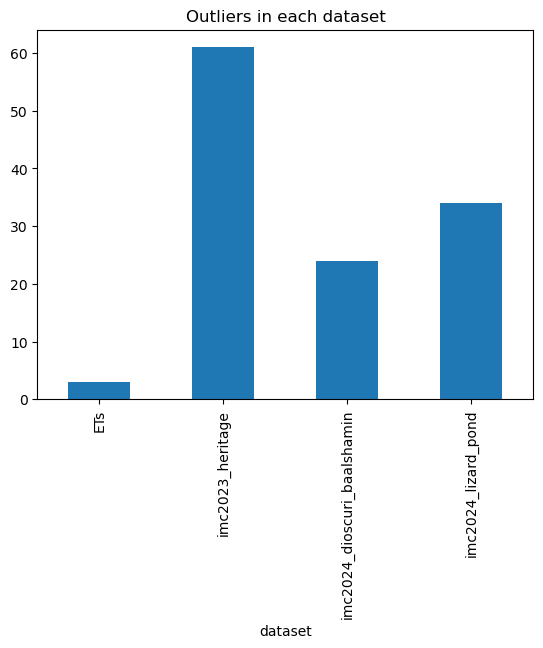

In [95]:
labels[labels['scene']=='outliers'].groupby('dataset').size().plot(kind='bar',title='Outliers in each dataset')

In [107]:
#labels.groupby(['dataset','scene']).count()
# Combination of each dataset and scene and total images for each

In [105]:
display(labels.groupby('dataset')['scene'].nunique())
display('Number of scenes per dataset')

dataset
ETs                                  3
amy_gardens                          1
fbk_vineyard                         3
imc2023_haiper                       3
imc2023_heritage                     4
imc2023_theather_imc2024_church      2
imc2024_dioscuri_baalshamin          3
imc2024_lizard_pond                  3
pt_brandenburg_british_buckingham    3
pt_piazzasanmarco_grandplace         2
pt_sacrecoeur_trevi_tajmahal         3
pt_stpeters_stpauls                  2
stairs                               2
Name: scene, dtype: int64

'Number of scenes per dataset'

# Dataset loading using dataloader and running each combination of descriptor + matcher

In [ ]:
from torch.utils.data import DataLoader

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset_eq_size, batch_size=2, shuffle=True, num_workers=4,pin_memory=True)

#train_features = next(iter(train_loader))
#print(f'Keys of the batch: {train_features.keys()}')
#print(f"Feature batch shape: {train_features['image'].size()}")
#print(f"Labels size: {labels.size}")


In [ ]:
''' Pseudo dataset containing descriptor pairs of each image so that we do not have to care about batching for each dataset.
Assuming descriptors saved in folders, where each file contains dataset name, image name and descriptor and key points.
Pseudo dataset will contain all the information(keys or columns of original dataset) for both the images image1 and image2.
Also, assuming the SIFT and DISK returns 'keypoints', 'keypoint_scores', 'descriptors', 'image_size' for each image.
'''

'''pseudo_dataset = PseudoMatchingDataset(
    labels_path='data/train_labels.csv',
    descriptors_dir='data/descriptors',
    descriptor_type='sift'
)

dataloader = DataLoader(
    pseudo_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)'''



In [ ]:
from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features
import os, h5py

import kornia

def save_result(save_dir,extractor,i,image, image_size, dataset_name, scene_name,image_name, image_path, res):
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, f"{i}_1024_{extractor}.h5")
    dt = h5py.string_dtype(encoding="utf-8")
    with h5py.File(out_path, 'w') as f:
        f.create_dataset('keypoints', data=res['keypoints'].cpu().detach().numpy())
        f.create_dataset('keypoint_scores', data=res['keypoint_scores'].cpu().detach().numpy())
        f.create_dataset('descriptors', data=res['descriptors'].cpu().detach().numpy())
        f.create_dataset('keypoints_mask', data=res['keypoints_mask'].cpu().detach().numpy())
        f.create_dataset('image', data=image.cpu().detach().numpy())
        print(image_size)
        f.create_dataset('image_size', data=image_size.cpu().detach().numpy())
        f.create_dataset('image_name', data=image_name, dtype=dt)
        f.create_dataset('dataset_name', data=dataset_name, dtype=dt)
        f.create_dataset('scene_name', data=scene_name, dtype=dt)
        f.create_dataset('image_path', data=image_path, dtype=dt)




for i,batch in enumerate(train_loader):
    torch.cuda.empty_cache()
    features = get_DISK_features(batch['image'].to(DEVICE), device = DEVICE)
    print(features.keys())
    save_result('evaluation/disk_descriptors_outputs/','disk',i,batch['image'], batch['image_size'],batch['dataset_name'], batch['scene_name'],batch['image_name'],batch['image_path'],features)
    del features
    break
    

In [ ]:
import h5py
import numpy as np
from pathlib import Path
'''To check if there are any zeros/false in mask for identifying the images which have been padded'''
root = Path("evaluation/disk_descriptors_outputs")

for h5_path in sorted(root.glob("*.h5")):
    print(f"\n=== {h5_path.name} ===")
    with h5py.File(h5_path, "r") as f:
        # Optional: show structure
        # f.visititems(print_h5_structure)

        if "keypoints_mask" not in f:
            print("keypoints_mask not found")
            continue

        mask = f["keypoints_mask"][:]  # shape (B, Nmax) typically
        zeros = np.where(mask == 0)
        total_zeros = zeros[0].size
        print(f"total zeros: {total_zeros}")

        # If you want the exact indices (batch_idx, kp_idx), print a small sample:
        if total_zeros > 0:
            sample = list(zip(zeros[0], zeros[1]))[:50]
            print(f"indices sample (up to 50): {sample}")

In [4]:
import h5py
import numpy as np
from pathlib import Path
import glob

root = Path("evaluation/disk_descriptors_outputs")
file_gen = root.glob("[0-9]*.h5")

if not file_gen:
    raise ValueError("No .h5 files found in the folder.")

first_file = next(file_gen)
with h5py.File(first_file, "r") as f:
    keys = list(f.keys())


with h5py.File(root / "merged.h5", "w") as fout:

    for key in keys:
        # Determine the dtype and initial shape from first file
        with h5py.File(first_file, "r") as f:
            data = f[key][...]
        fout.create_dataset(key, data=data, maxshape=(None,) + data.shape[1:])

    #iterate over the remaining files
    for filepath in file_gen:  
        with h5py.File(filepath, "r") as f:
            for key in keys:
                old_data = fout[key]
                new_data = f[key][...]
                old_len = old_data.shape[0]
                new_len = new_data.shape[0]
                old_data.resize(old_len + new_len, axis=0)
                old_data[old_len:] = new_data


In [5]:
import h5py
import numpy as np
def print_h5_structure(name, obj):
    print(name)

with h5py.File("evaluation/disk_descriptors_outputs/merged.h5", "r") as f:
    for key in f.keys():
        num_rows = f[key]
        print(f"{key}: {num_rows} rows")

dataset_name: <HDF5 dataset "dataset_name": shape (1945,), type "|O"> rows
descriptors: <HDF5 dataset "descriptors": shape (1945, 2048, 128), type "<f4"> rows
image: <HDF5 dataset "image": shape (1945, 3, 1024, 1024), type "<f4"> rows
image_name: <HDF5 dataset "image_name": shape (1945,), type "|O"> rows
image_path: <HDF5 dataset "image_path": shape (1945,), type "|O"> rows
keypoint_scores: <HDF5 dataset "keypoint_scores": shape (1945, 2048), type "<f4"> rows
keypoints: <HDF5 dataset "keypoints": shape (1945, 2048, 2), type "<f4"> rows
keypoints_mask: <HDF5 dataset "keypoints_mask": shape (1945, 2048), type "<f4"> rows
scene_name: <HDF5 dataset "scene_name": shape (1945,), type "|O"> rows


In [3]:
from data_preprocess.image_pair_csv_dataset import ImagePairCsv
import pandas as pd

image_pair_csv = ImagePairCsv(labels_path='data/train_labels.csv', output_dir='data/train_pairs')

pairs_csv = pd.read_csv('data/train_pairs/data_pairs.csv')
print(pairs_csv.head())

                   image1                  image2         dataset
0  fountain_image_116.png  fountain_image_108.png  imc2023_haiper
1  fountain_image_116.png  fountain_image_101.png  imc2023_haiper
2  fountain_image_116.png  fountain_image_082.png  imc2023_haiper
3  fountain_image_116.png  fountain_image_071.png  imc2023_haiper
4  fountain_image_116.png  fountain_image_025.png  imc2023_haiper


In [6]:
from data_preprocess.pseudo_dataset_matching import PseudoMatchingDataset
from torch.utils.data import DataLoader
import torch

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')

print(DEVICE)
pseudo_matching_dataset = PseudoMatchingDataset(pairs_path='data/train_pairs/data_pairs.csv', descriptors_path='evaluation/disk_descriptors_outputs/merged.h5', descriptor_type='disk', device=DEVICE )

train_loader = DataLoader(pseudo_matching_dataset, batch_size=2, num_workers=1, shuffle=False)#,pin_memory=True)

#train_features = next(iter(train_loader))
#print(f'Keys of the batch: {train_features.keys()}')
#print(f"Feature batch shape: {train_features['features1']}")

cuda:0


In [2]:
import h5py
from pathlib import Path
from feature_matching.lightglue_matcher import match_features_for_plots
import cv2 as cv
import numpy as np
from batch_matcher import process_batches

# Set up output path
output_dir = Path('evaluation/matches_output')
output_dir.mkdir(exist_ok=True, parents=True)

# Initialize output files for both matchers
lightglue_output = output_dir / 'disk_lightglue_matches.h5'
flann_output = output_dir / 'disk_flann_matches.h5'


# Run both matchers
print("Running LightGlue matching...")
lightglue_matches = process_batches(
    train_loader,
    matcher='lightglue',
    output_path=lightglue_output,
    device = DEVICE
)

print("\nRunning FLANN matching...")
flann_matches = process_batches(
    train_loader,
    matcher='flann',
    output_path=flann_output
)

print("\nMatching complete!")
print(f"LightGlue matches saved to: {lightglue_output}")
print(f"FLANN matches saved to: {flann_output}")

# Print some statistics
print("\nMatching Statistics:")
print("LightGlue:")
print(f"Total pairs processed: {len(lightglue_matches)}")
print(f"Average matches per pair: {np.mean([len(m['matches']) for m in lightglue_matches]):.1f}")

print("\nFLANN:")
print(f"Total pairs processed: {len(flann_matches)}")
print(f"Average matches per pair: {np.mean([len(m['matches_idx']) for m in flann_matches]):.1f}")

Running LightGlue matching...
Processing 88599 batches with lightglue...
Batch 1/88599


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [8]:

from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features

feats0 = get_SIFT_features(train_dataset[12].get('image_path'))
print(feats0['keypoints'].size())
print(feats0['descriptors'].size())

feats01 = get_SIFT_features(train_dataset[12].get('image_path'))
#print(feats01)

points0, points1 = match_features(image0_features=feats0, image1_features=feats01, descriptor='sift')

#print(len(points0))
#print(len(points1))

feats0 = get_DISK_features(train_dataset[1100].get('image_path'))
print(feats0.keys())
print(feats0['keypoints'].size())
print(feats0['descriptors'].size())
feats01 = get_DISK_features(train_dataset[1000].get('image_path'))
print(feats01.keys())
print(feats01['keypoints'].size())
print(feats01['descriptors'].size())

torch.Size([1, 1522, 2])
torch.Size([1, 1522, 128])
dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 128])
dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])
torch.Size([1, 2048, 2])
torch.Size([1, 2048, 128])


In [1]:

def print_evaluation_results(results: dict):
    """Print formatted evaluation results"""
    print(f"Cluster Evaluation Results:")
    print(f"---------------------------")
    print(f"Total Clusters: {results['total_clusters']}")
    print(f"Correct Clusters: {results['correct_clusters']}")
    print(f"Scene Purity: {results['scene_purity']:.2%}")
    print("\nPer-cluster Statistics:")
    
    for cluster_id, stats in results['per_cluster_stats'].items():
        print(f"\nCluster {cluster_id}:")
        print(f"  Size: {stats['size']} images")
        print(f"  Pure cluster: {stats['is_pure']}")
        print(f"  Number of scenes: {stats['num_scenes']}")
        print(f"  Scenes: {', '.join(stats['scenes'])}")

In [2]:
data_fake_cluster = {0: ['peach_0019.png', 'peach_0067.png', 'peach_0166.png'],
 1: ['peach_0010.png',
   'peach_0015.png',
   'peach_0032.png',
   'peach_0068.png',
   'peach_0069.png',
   'peach_0115.png',
   'peach_0123.png',
   'peach_0133.png',
   'peach_0142.png',
   'peach_0144.png',
   'peach_0147.png',
   'peach_0158.png',
   'peach_0165.png',
   'peach_0168.png',
   'peach_0186.png'],
 2: ['peach_0006.png',
   'peach_0020.png',
   'peach_0024.png',
   'peach_0026.png',
   'peach_0040.png',
   'peach_0084.png',
   'peach_0116.png',
   'peach_0118.png',
   'peach_0127.png'],
 5: ['peach_0013.png', 'peach_0096.png', 'peach_0181.png']}

In [3]:
from evaluation.eval import evaluate_clusters

evaluate_clusters(data_fake_cluster, labels_path='data/train_labels.csv')

scene
ET                        9
another_ET               10
baalshamin               49
bike                     15
brandenburg_gate         75
british_museum           75
buckingham_palace        75
chairs                   16
church                   50
cyprus                   30
dioscuri                140
fountain                 23
grand_place_brussels    100
kyiv-puppet-theater      26
lizard                   90
outliers                122
peach                   200
piazza_san_marco         68
pond                     90
sacre_coeur              75
st_pauls_cathedral      100
st_peters_square        100
stairs_split_1           28
stairs_split_2           23
taj_mahal                75
trevi_fountain           75
vineyard_split_1         43
vineyard_split_2         35
vineyard_split_3         85
wall                     43
Name: image, dtype: int64
{'peach_0019.png', 'peach_0166.png', 'peach_0067.png'}
{'peach_0133.png', 'peach_0168.png', 'peach_0123.png', 'peach_0010.png', 

{'overall_mAA': 0.0025,
 'overall_clustering_score': 0.03333333333333333,
 'combined_score': 0.004651162790697674,
 'per_scene_results': {'ET': {'cluster_id': 0,
   'mAA': 0.0,
   'clustering_score': 0.0},
  'another_ET': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'baalshamin': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'bike': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'brandenburg_gate': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'british_museum': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'buckingham_palace': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'chairs': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'church': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'cyprus': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'dioscuri': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'fountain': {'cluster_id': 0, 'mAA': 0.0, 'clustering_score': 0.0},
  'gran